In [ ]:
# Этап 1. Генерация данных
# Для генераии данных возможно выбрать поднабор изображений в количестве 10-50 шт, "нарезку" патчей выполнить по ним.
# Изучите набор данных, располагающийся в архиве blood_cells.
# Выполните "нарезку" изображений. Сохраните в отдельные папки изображения фона и изображения клеток.
# Реализуйте генератор данных снимков клеток крови. На выходе генератор предосталвяет два изображения: сгенерированное без шума, сгенерированное с шумом.
# Патчи для формирования фона: 
# 1) патчи, вырезанные из исходного набора данных 
# 2) искусственно сформированные патчи (равномерная заливка фона из диапазона допустимых значений)
# Фон изображения формируется из набора патчей. 
# Патчи для клеток крови:
# 1) патчи, вырезанные из исходного набора данных
# 2) искусствено сгенерированные окружности с заливкой из допустимого набора данных
# для blending-задачи применять: https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
# Примеры генераторов и загрузчиков данных найдете в исходной папке.
##########
# Основные этапы генерации:
# 1. Выбор, формирование патчей, их препроцессинг. Формирование(комбинирование) фона из набора патчей. Постпроцессинг результирующего фона.
# 2. Выбор метоположения клекток, выбор/формирование клеток, совмещение клеток на фоновом изображении
# 3. Выбор типа шума. Зашумление изображения. 
#
# Генератор возвращает два изображения: зашумленное (этап 3) и исходное (этап 2) изображения.
#
# Этап 2. Исследование качества работы алгоритмов шумоподавления на сформированном датасете.
# Виды шумов:
# 1) Шум Гаусса
# 2) постоянный шум
# Виды фильтров:
# 1) Медианный фильтр
# 2) фильтр гаусса
# 3) билатериальный фильтр 
# 4) фильтр нелокальных средних с различными параметрами.
# 5.1) самостоятелная реализация алгоритма шумоподавления (CPU)
# 5.2) самостоятелная реализация алгоритма шумоподавления (GPU)
# Метрики:
# 1) MSE
# 2) SSIM
# 3) время работы
# 

In [113]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from glob import glob
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt
from glob import glob
from skimage.metrics import mean_squared_error
import time
from skimage.metrics import structural_similarity, mean_squared_error

In [101]:
cells_path = 'cl'
background_path = 'bg'

In [190]:
for filename in os.listdir(background_path):
    img=Image.open('bg/' + filename)
    rimg = img.resize((32,32))
    rimg.save('bg/' + filename)
for filename in os.listdir(cells_path):
    img=Image.open('cl/' + filename)
    rimg = img.resize((64,64))
    rimg.save('cl/' + filename)

In [298]:
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt

def bg_create():
    bg = np.zeros((512,512,3), dtype=np.uint8)
    patch = glob(os.path.join('bg/',"*.png"))
    for i in range(512//32):
        for j in range(512//32):
            p = cv2.imread(random.choice(patch),cv2.IMREAD_GRAYSCALE)
            p = cv2.cvtColor(p, cv2.COLOR_GRAY2BGR)
            bg[i*32:(i+1)*32,j*32:(j+1)*32] = p
    return bg
def cell_create(bg):
    cells = glob(os.path.join('cl/',"*.png"))
    cell = cv2.imread(random.choice(cells),cv2.IMREAD_GRAYSCALE)
    cell = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
    mask = 255 * np.ones(cell.shape, dtype=np.uint8)
    place = (random.randint(0, 512 - 64) + 64 // 2, random.randint(0, 512 - 64) + 64 // 2)
    img = cv2.seamlessClone(cell,bg,mask,place,cv2.NORMAL_CLONE)
    return img
def gauss(img):
    mean = 0
    stddev = 100
    noise_gauss = np.zeros(img.shape, np.uint8)
    cv2.randn(noise_gauss, mean, stddev)
    img = cv2.add(img,noise_gauss)
    return img
def const(img):
    img = cv2.add(img, 10)
    return img
def generate():
    while 1:
        img = bg_create()
        for i in range(random.randint(1,10)):
            img = cell_create(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gs = gauss(img)
        ct = const(img)
        yield img, gs, ct

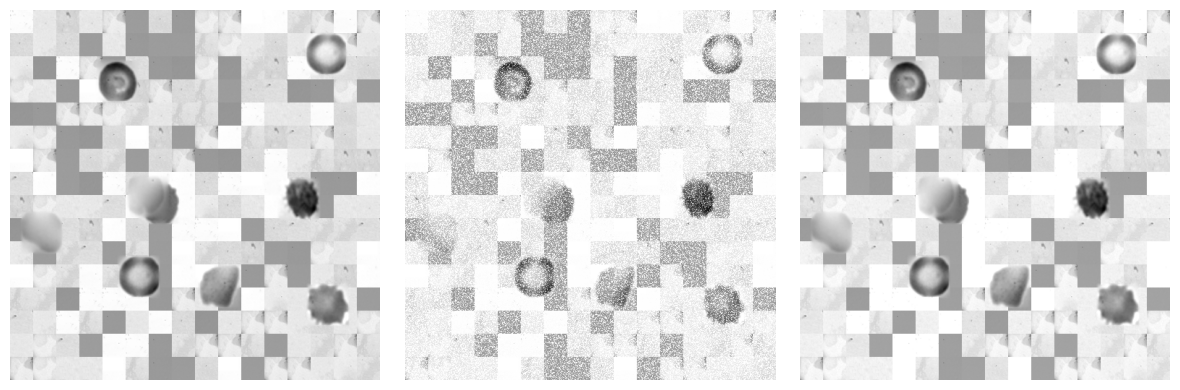

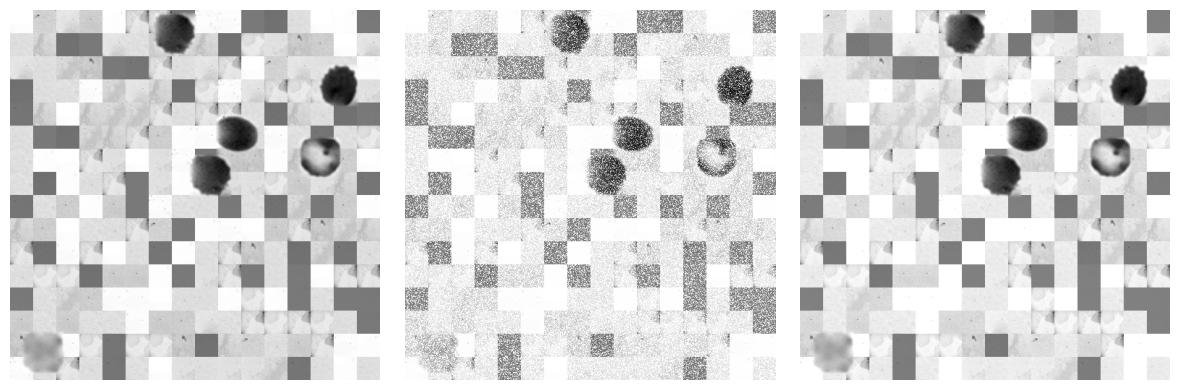

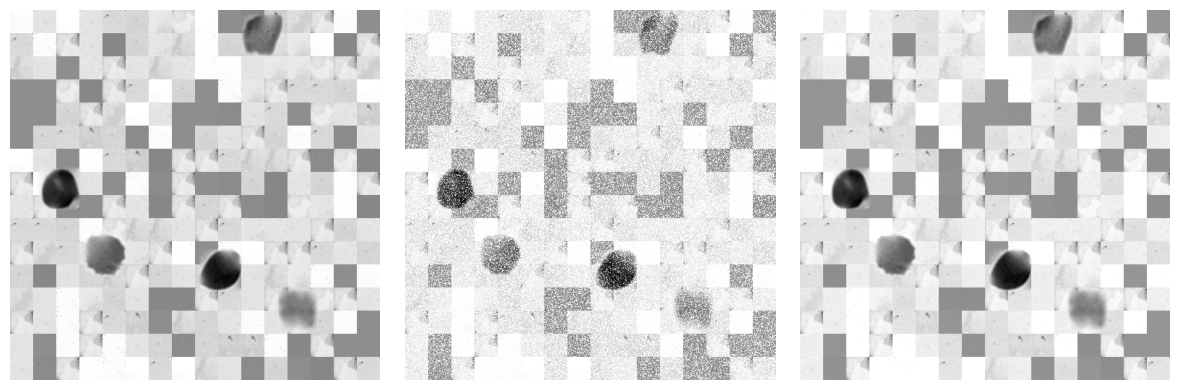

In [332]:
gen = generate() 

mse_m = [[0,0,0],[0,0,0]]
ssim_m = [[0,0,0],[0,0,0]]
time_m = [[0,0,0],[0,0,0]]

mse_g = [[0,0,0],[0,0,0]]
ssim_g = [[0,0,0],[0,0,0]]
time_g = [[0,0,0],[0,0,0]]

mse_b = [[0,0,0],[0,0,0]]
ssim_b = [[0,0,0],[0,0,0]]
time_b = [[0,0,0],[0,0,0]]

mse_n = [[0,0,0],[0,0,0]]
ssim_n = [[0,0,0],[0,0,0]]
time_n = [[0,0,0],[0,0,0]]

for i in range(3):
    img, gs, ct = next(gen)
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(gs, cmap = 'gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(ct, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout()

    start_time = time.time()
    image_gauss = cv2.medianBlur(gs, 3)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_m[0][i] = mse_gauss_median
    ssim_m[0][i] = ssim_gauss_median
    time_m[0][i] = end_time - start_time
    start_time = time.time()
    image_gauss = cv2.medianBlur(ct, 3)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_m[1][i] = mse_gauss_median
    ssim_m[1][i] = ssim_gauss_median
    time_m[1][i] = end_time - start_time
    
    start_time = time.time()
    image_gauss = cv2.GaussianBlur(gs,(5,5),0)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_g[0][i] = mse_gauss_median
    ssim_g[0][i] = ssim_gauss_median
    time_g[0][i] = end_time - start_time
    start_time = time.time()
    image_gauss = cv2.GaussianBlur(ct,(5,5),0)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_m[1][i] = mse_gauss_median
    ssim_m[1][i] = ssim_gauss_median
    time_m[1][i] = end_time - start_time

    start_time = time.time()
    image_gauss = cv2.bilateralFilter(gs,9,75,75)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_b[0][i] = mse_gauss_median
    ssim_b[0][i] = ssim_gauss_median
    time_b[0][i] = end_time - start_time
    start_time = time.time()
    image_gauss = cv2.bilateralFilter(ct,9,75,75)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_b[1][i] = mse_gauss_median
    ssim_b[1][i] = ssim_gauss_median
    time_b[1][i] = end_time - start_time

    start_time = time.time()
    image_gauss = cv2.fastNlMeansDenoising(gs, 10, 7, 21)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_n[0][i] = mse_gauss_median
    ssim_n[0][i] = ssim_gauss_median
    time_n[0][i] = end_time - start_time
    start_time = time.time()
    image_gauss = cv2.fastNlMeansDenoising(ct, 10, 7, 21)
    end_time = time.time()
    mse_gauss_median = mean_squared_error(img, image_gauss)
    (ssim_gauss_median, diff) = structural_similarity(img,  image_gauss, full=True)
    mse_n[1][i] = mse_gauss_median
    ssim_n[1][i] = ssim_gauss_median
    time_n[1][i] = end_time - start_time

In [333]:
print(f"Median - MSE = {sum(mse_m[0])/3}, SSIM = {sum(ssim_m[0])/3}, TIME = {sum(time_m[0])/3}")
print(f"Gauss - MSE = {sum(mse_g[0])/3}, SSIM = {sum(ssim_g[0])/3}, TIME = {sum(time_g[0])/3}")
print(f"Bilateral - MSE = {sum(mse_b[0])/3}, SSIM = {sum(ssim_b[0])/3}, TIME = {sum(time_b[0])/3}")
print(f"NLMeans - MSE = {sum(mse_n[0])/3}, SSIM = {sum(ssim_n[0])/3}, TIME = {sum(time_n[0])/3}")

Median - MSE = 426.2677230834961, SSIM = 0.47569582370734914, TIME = 0.0003229777018229167
Gauss - MSE = 428.52297337849933, SSIM = 0.7370890899065952, TIME = 0.0001766681671142578
Bilateral - MSE = 425.87982177734375, SSIM = 0.7283414848628814, TIME = 0.0027413368225097656
NLMeans - MSE = 873.2696431477865, SSIM = 0.4389080218554393, TIME = 0.39929620424906415


In [334]:
print(f"Median - MSE = {sum(mse_m[1])/3}, SSIM = {sum(ssim_m[1])/3}, TIME = {sum(time_m[1])/3}")
print(f"Gauss - MSE = {sum(mse_g[1])/3}, SSIM = {sum(ssim_g[1])/3}, TIME = {sum(time_g[1])/3}")
print(f"Bilateral - MSE = {sum(mse_b[1])/3}, SSIM = {sum(ssim_b[1])/3}, TIME = {sum(time_b[1])/3}")
print(f"NLMeans - MSE = {sum(mse_n[1])/3}, SSIM = {sum(ssim_n[1])/3}, TIME = {sum(time_n[1])/3}")

Median - MSE = 114.18206787109375, SSIM = 0.9274595015672378, TIME = 0.0001815160115559896
Gauss - MSE = 0.0, SSIM = 0.0, TIME = 0.0
Bilateral - MSE = 131.0802141825358, SSIM = 0.869531767466505, TIME = 0.0029915173848470054
NLMeans - MSE = 99.14547602335612, SSIM = 0.9186889482318991, TIME = 0.40138840675354004
